### Final model training
Based on the hyperparameters found in training_1, we train our final FFNN and CNN models on our extracted features CSV (dataset_extracted/features_3_sec_extracted.csv)
[Our models are based on a combination of a number of notebooks found here.](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/code)


In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization, Conv1D, MaxPooling1D, Reshape
from tensorflow.keras.models import load_model

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
dataset = pd.read_csv("dataset_extracted/features_3_sec_extracted.csv")
dataset = dataset.drop(labels="filename", axis=1)

In [7]:
# Get classes and encode these to numerical values (0 to 9)

class_list = dataset.iloc[:, -1]
convertor = LabelEncoder()
y = convertor.fit_transform(class_list)

In [8]:
# Get all data except label and standardize features

fit = StandardScaler()
X = fit.fit_transform(np.array(dataset.iloc[:, :-1], dtype = float))
X.shape

(9981, 58)

In [9]:
# Split data into train, validation and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [33]:
# best params FFNN: {'optimizer': 'adam', 'epochs': 300, 'dropout_rate': 0.4, 'batch_size': 256}

model_ffnn = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation="relu"),
    Dropout(0.4),
    Dense(256, activation="relu"),
    Dropout(0.4),
    Dense(128,activation="relu"),
    Dropout(0.4),
    Dense(64,activation="relu"),
    Dropout(0.4),
    Dense(32,activation="relu"),
    Dropout(0.4),
    Dense(10, activation='softmax')
])

model_ffnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
ffnn_history = model_ffnn.fit(X_train, y_train, batch_size=256, epochs=300)

Epoch 1/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.1370 - loss: 2.2995
Epoch 2/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2613 - loss: 2.0387
Epoch 3/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3057 - loss: 1.8557
Epoch 4/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3690 - loss: 1.7219
Epoch 5/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4221 - loss: 1.6036
Epoch 6/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4585 - loss: 1.5146
Epoch 7/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5000 - loss: 1.4157
Epoch 8/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5279 - loss: 1.3548
Epoch 9/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5557 - loss: 1.3014
Epoch 10/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5851 - loss: 1.2438
Epoch 11/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6024 - loss: 1.1961
Epoch 12/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

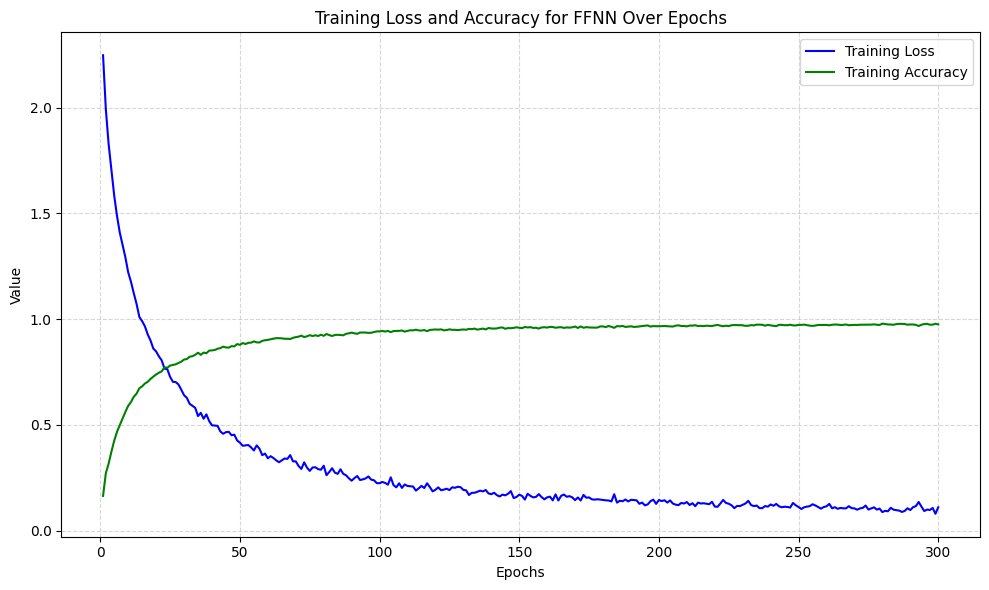

In [50]:
plt.figure(figsize=(10, 6))

epochs = range(1, len(ffnn_history.history['loss']) + 1)
plt.plot(epochs, ffnn_history.history['loss'], label='Training Loss', color='blue')

plt.plot(epochs, ffnn_history.history['accuracy'], label='Training Accuracy', color='green')

plt.title('Training Loss and Accuracy for FFNN Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [35]:
y_pred_ffnn = model_ffnn.predict(X_test)
y_pred_ffnn_classes = np.argmax(y_pred_ffnn, axis=1)
test_accuracy_ffnn = accuracy_score(y_test, y_pred_ffnn_classes)
print(f"Test Accuracy: {test_accuracy_ffnn:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test Accuracy: 0.9229


In [46]:
model_ffnn.save("checkpoints/trained_ffnn_3_sec.keras", include_optimizer=True)

In [47]:
loaded_model_ffnn = load_model("checkpoints/trained_ffnn_3_sec.keras")
loaded_y_pred_ffnn = loaded_model_ffnn.predict(X_test)
loaded_y_pred_ffnn_classes = np.argmax(loaded_y_pred_ffnn, axis=1)
loaded_test_accuracy_ffnn = accuracy_score(y_test, loaded_y_pred_ffnn_classes)
print(f"Test Accuracy: {loaded_test_accuracy_ffnn:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test Accuracy: 0.9229


In [39]:
# {'optimizer': 'adam', 'epochs': 300, 'dropout_rate': 0.3, 'batch_size': 64}

model_cnn = Sequential([
    Input(shape=(58,)),
    Reshape((58, 1)),
    Conv1D(32, 3, activation="relu"),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),
    Conv1D(64, 3, activation="relu"),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(10, activation="softmax")
])

model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [40]:
cnn_history = model_cnn.fit(X_train, y_train, batch_size=64, epochs=300, callbacks=[early_stopping])

Epoch 1/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3635 - loss: 2.0625
Epoch 2/300
 65/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5897 - loss: 1.1857

/home/hylke/miniconda3/envs/musicgenreclassification/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5974 - loss: 1.1672
Epoch 3/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6551 - loss: 0.9866
Epoch 4/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6901 - loss: 0.8929
Epoch 5/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7077 - loss: 0.8380
Epoch 6/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7331 - loss: 0.7757
Epoch 7/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7528 - loss: 0.7107
Epoch 8/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7750 - loss: 0.6364
Epoch 9/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7924 - loss: 0.6100
Epoch 10/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8098 - loss: 0.5483
Epoch 11/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8128 - loss: 0.5367
Epoch 12/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8218 - loss: 0.5135
Epoch 13/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

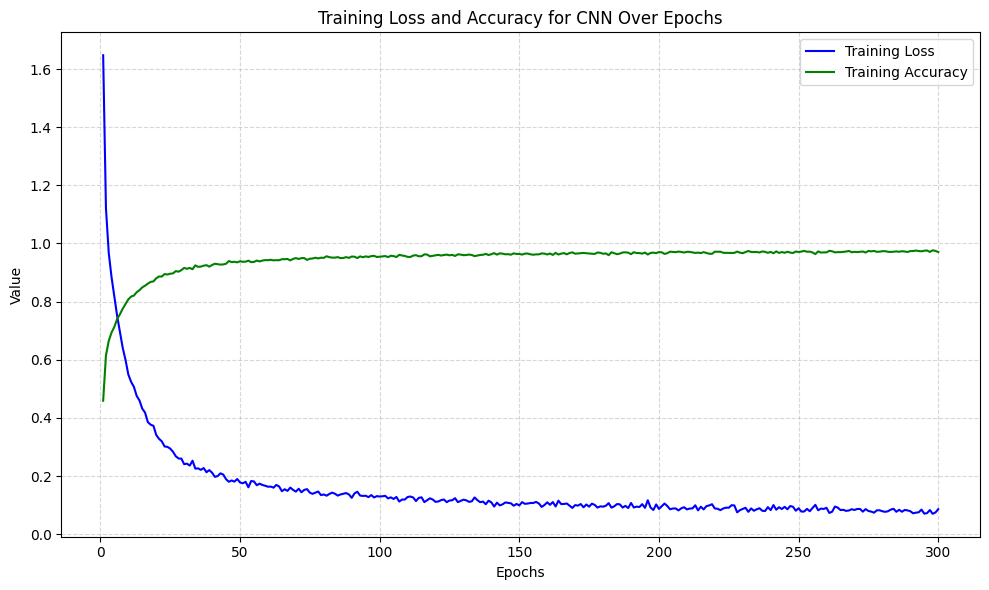

In [49]:
plt.figure(figsize=(10, 6))

epochs = range(1, len(cnn_history.history['loss']) + 1)
plt.plot(epochs, cnn_history.history['loss'], label='Training Loss', color='blue')

plt.plot(epochs, cnn_history.history['accuracy'], label='Training Accuracy', color='green')

plt.title('Training Loss and Accuracy for CNN Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

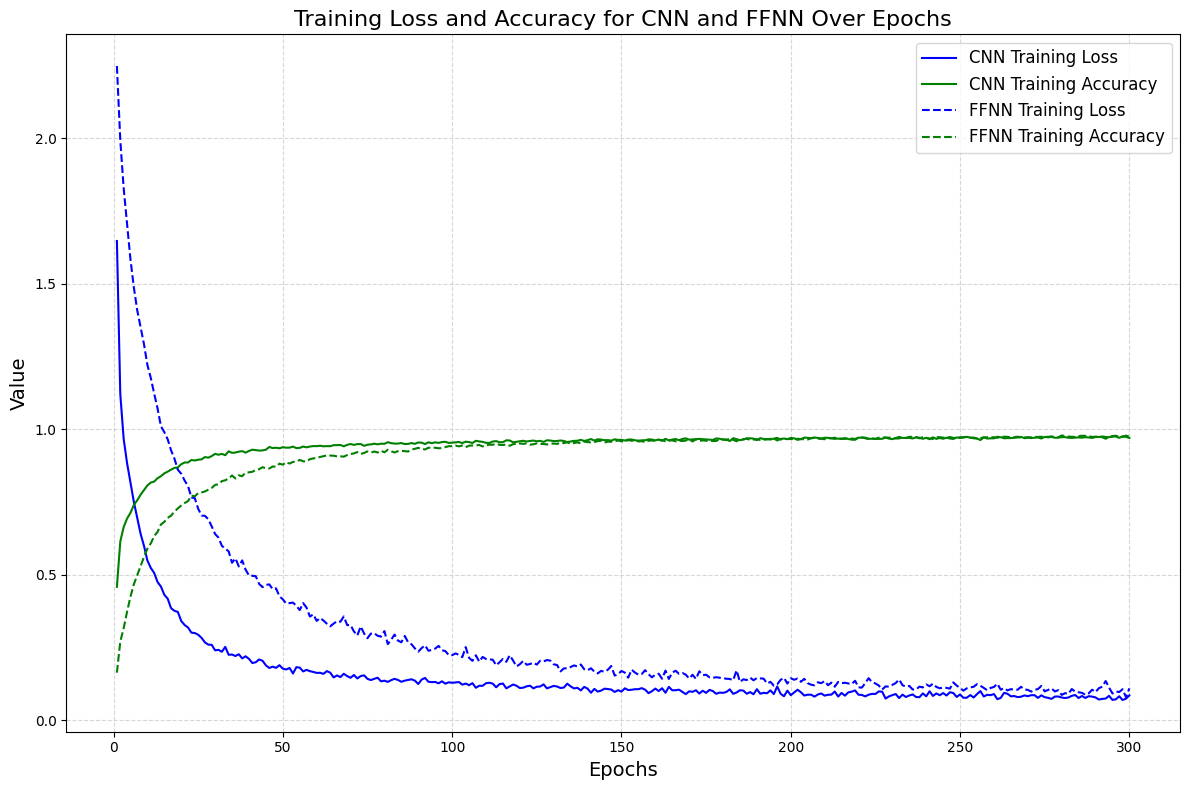

In [43]:
plt.figure(figsize=(12, 8))

cnn_epochs = range(1, len(cnn_history.history['loss']) + 1)
ffnn_epochs = range(1, len(ffnn_history.history['loss']) + 1)

plt.plot(cnn_epochs, cnn_history.history['loss'], label='CNN Training Loss', color='blue')
plt.plot(cnn_epochs, cnn_history.history['accuracy'], label='CNN Training Accuracy', color='green')

plt.plot(ffnn_epochs, ffnn_history.history['loss'], label='FFNN Training Loss', color='blue', linestyle='dashed')
plt.plot(ffnn_epochs, ffnn_history.history['accuracy'], label='FFNN Training Accuracy', color='green', linestyle='dashed')

plt.title('Training Loss and Accuracy for CNN and FFNN Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [41]:
y_pred_cnn = model_cnn.predict(X_test)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
test_accuracy_cnn = accuracy_score(y_test, y_pred_cnn_classes)
print(f"Test Accuracy: {test_accuracy_cnn:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Accuracy: 0.9055


In [45]:
model_cnn.save("checkpoints/trained_cnn_3_sec.keras", include_optimizer=True)

In [48]:
loaded_model_cnn = load_model("checkpoints/trained_cnn_3_sec.keras")
loaded_y_pred_cnn = loaded_model_cnn.predict(X_test)
loaded_y_pred_cnn_classes = np.argmax(loaded_y_pred_cnn, axis=1)
loaded_test_accuracy_cnn = accuracy_score(y_test, loaded_y_pred_cnn_classes)
print(f"Test Accuracy: {loaded_test_accuracy_cnn:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Accuracy: 0.9055
